## Modelo de clasificación para caso de fuga en Telco Co: Fase de Análisis de los datos

A través de este dataset de ejemplo, el cual se encuentra en el sitio de Kaggle [Data Source: IBM Cognos Telco Customer Churn Dataset](https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset), se analiza el caso de una empresa de telecomunicaciones ficticia llamada **Telco Co.**, la cual presenta un problema de de fuga de clientes, ya que el 26,5% de ellos abandonaron en el último período. Se cubre desde la fase de análisis, procesamiendo e ingeniería de datos, hasta la generación de los modelos estadísticos que expliquen la razón de este fenómeno.

El modelo predictivo debería cumplir con los siguientes requisitos comerciales:

   * Encuentrar el mejor modelo de predicción inicial para clasificar el riesgo de pérdida de clientes
   * El rendimiento del modelo debería ser significativamente mejor que el uso de "promedios".
   * Los entregables deben explicar la influencia relativa que cada predictor tiene en las predicciones generales del modelo.
   * Los entregables deben sugerir posibles soluciones para reducir la rotación de clientes
  
Telco Co. proporcionó datos históricos selectos sobre 7.043 clientes, incluido un indicador de si cada cliente abandonó. Después de analizar y transformar los datos, optimizamos varios modelos de clasificación. Cada modelo se entrenó en el 80% de los datos históricos y luego se les pidió que pronosticaran las puntuaciones de abandono en el 20% restante de los datos de prueba. Cada modelo se comparó con el mejor modelo anterior con el modelo XG Boost con el mejor rendimiento:

## Data Engineering

### Importando las librerías y definiendo funciones

In [1]:
## Librerías a utilizar

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
pd.pandas.set_option('display.max_columns',None)

# Elimina notacion cientifica y restricciones de filas y columnas
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
sns.set(context='paper', style='darkgrid', 
        rc={'figure.facecolor':'white'}, font_scale=1.2)

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
# sklearn.metrics import:
# * make_scorer
# * euclidean_distances 
# * precision_recall_curve
# * classification_report
# * plot_confusion_matrix
# * confusion_matrix
# * roc_curve
# * auc
# * f1_score
# * roc_auc_score
# * accuracy_score
# * precision_score
# * recall_score
from sklearn.metrics import *
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Varios
# ==============================================================================
import os
from urllib import request
from six.moves import urllib
import multiprocessing
import random
from itertools import product

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Variables
# ==============================================================================
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/fvgm-spec/ML/main/" # Establece la ruta de la url de descarga donde se encuentra el archivo csv
PATH = "data/" # carpeta de la url de descarga donde se encuentra el archivo csv
#data/Telco_customer_churn.csv
FOLDER = "plots"
FILE = "Telco_customer_churn.csv" # nombre del archivo que se va a descargar (cambiarlo de ser necesario)
PROJECT_NAME = FILE[0:-4] # establece como nombre de proyecto la porcion del nombre de archivo que antecede la extension .csv
URL = DOWNLOAD_ROOT + PATH + FILE  
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images/" + PROJECT_NAME, FOLDER)

## Funciones
# ==============================================================================
# Recupera los datos de la url establecida en las variables
def fetching_data(url=URL, path=PATH, file=FILE):
    """
    Esta funcion descarga de la URL donde estan almacenados los datos del analisis,
    crea un directorio en la misma carpeta del proyecto y almacena el archivo csv
    """
    if not os.path.isdir(path): # si no esta creado un directorio correspondiente a la variable 'path'
        os.makedirs(path) # se crea el directorio en la raiz con el nombre de la variable path
    csv_path = os.path.join(path, file) # crea el path del archivo compuesto por las variables path y file
    urllib.request.urlretrieve(url, csv_path) # va a la url establecida por la variable url y copia el archivo en la carpeta local


# Guarda los plots generados por matplotlib como .png en el directorio de imagenes
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Esta funcion guarda los plot generados con matplotlib en una carpeta de imagenes
    que es creada  haciendo uso de esta misma funcion
    """
    os.makedirs(IMAGES_PATH, exist_ok=True) # crea la ruta para guardar las graficas
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension) # establece el path para almacenar los plots
    print("Saving figure", fig_id) # muestra el mensaje en el notebook
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Lee el archivo de la carpeta local
def load_data(path=PATH, file=FILE):
    csv_path = os.path.join(path, file)
    return pd.read_csv(csv_path, sep=",")

### Dictionario de datos

  * CustomerID: A unique ID that identifies each customer.
  * Count: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.
  * Country: The country of the customer’s primary residence.
  * State: The state of the customer’s primary residence.
  * City: The city of the customer’s primary residence.
  * Zip Code: The zip code of the customer’s primary residence.
  * Lat Long: The combined latitude and longitude of the customer’s primary residence.
  * Latitude: The latitude of the customer’s primary residence.
  * Longitude: The longitude of the customer’s primary residence.
  * Gender: The customer’s gender: Male, Female
  * Senior Citizen: Indicates if the customer is 65 or older: Yes, No
  * Partner: Indicate if the customer has a partner: Yes, No
  * Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
  * Tenure Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.
  * Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
  * Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No
  * Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
  * Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
  * Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No
  * Device Protection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No
  * Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No
  * Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.
  * Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.
  * Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
  * Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
  * Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
  * Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.
  * Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.
  * Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.
  * Churn Value: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.
  * Churn Score: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.
  * CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.
  * Churn Reason: A customer’s specific reason for leaving the company. Directly related to Churn Category.

### Importando los datos

Haremos uso de la funcion anteriormente definida para leer los datos e importarlos desde la URL. Estos quedarán almacenados en la carpeta `data` de este mismo directorio.

In [2]:
fetching_data()

### Análisis básico de los datos

Antes de entrenar un modelo predictivo, o incluso antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar una exploración descriptiva de los mismos. Este proceso permite entender mejor qué información contiene cada variable, así como detectar posibles errores. Algunos ejemplos frecuentes son:

* Que una columna se haya almacenado con el tipo incorrecto: una variable numérica está siendo reconocida como texto o viceversa.

* Que una variable contenga valores que no tienen sentido: por ejemplo, para indicar que no se dispone del precio de una vivienda se introduce el valor 0 o un espacio en blanco.

* Que en una variable de tipo numérico se haya introducido una palabra en lugar de un número.

Además, este análisis inicial puede dar pistas sobre qué variables son adecuadas como predictores en un modelo (más sobre esto en los siguientes apartados).

Junto con el estudio del tipo de variables, es básico conocer el número de observaciones disponibles y si todas ellas están completas. Los valores ausentes son muy importantes a la hora de crear modelos, la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas. Aunque la imputación de valores ausentes es parte del preprocesado y, por lo tanto, debe de aprenderse únicamente con los datos de entrenamiento, su identificación se tiene que realizar antes de separar los datos para asegurar que se establecen todas las estrategias de imputación necesarias.

Para comenzar a analizar los datos, se utiliza la funcion customizada `load_data` la cual toma el archivo csv que de descargo anteriormente desde la ruta `data`. Luego de ello se vizualizan con la función `head()` las primeras 5 filas del dataset

In [3]:
## Analizando los datos
data = load_data()
data.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964,-118.273,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059,-118.307,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048,-118.294,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062,-118.316,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039,-118.266,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.700,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
# Elimina las columnas que no harán falta para el análisis
drop_cols = ['Latitude', 'Longitude', 'Churn Label']
data.drop(drop_cols, axis=1, inplace=True)

In [5]:
# Convierte los nombres de columna a lower case incluyendo underscore
data.columns = data.columns.str.lower().str.replace(' ','_')

### Visualizando informacion del dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         7043 non-null   object 
 1   count              7043 non-null   int64  
 2   country            7043 non-null   object 
 3   state              7043 non-null   object 
 4   city               7043 non-null   object 
 5   zip_code           7043 non-null   int64  
 6   lat_long           7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  tenure_months      7043 non-null   int64  
 12  phone_service      7043 non-null   object 
 13  multiple_lines     7043 non-null   object 
 14  internet_service   7043 non-null   object 
 15  online_security    7043 non-null   object 
 16  online_backup      7043 

<p style="color:red;">OBSERVACIONES DEL DATASET</p>

  * **La columna _churn_reason_ contiene un 26.5% de valores nulos**
  * **_total_charges_ debería ser un valor numérico (float)**
  * **Convertir indicadores de columnas de _yes/no_ a _1/0_**

Adicionalmente podemos hacer uso de una funcion customizada almacenada en la carpeta _functions_ dentro de este mismo directorio de este proyecto, la cual genera un reporte que agrupa las siguientes columnas:

 * El nombre de cada columna del dataset,
 * su tipo de dato, 
 * una muestra de los primeros 5 registros de cada columna, 
 * la cantidad de valores unicos y 
 * en caso de tenerlos la cantidad de valores nulos del conjunto de datos . 

In [7]:
from functions.report import report
print(f'Este set de datos cuenta con {data.shape[0]} columnas y {data.shape[1]} filas')
report(data)

Este set de datos cuenta con 7043 columnas y 30 filas


,Column,d_type,unique_sample,n_uniques,nas
0,customerid,object,['3668-QPYBK' '9237-HQITU' '9305-CDSKC' '7892-POOKP' '0280-XJGEX'],7043,0
1,count,int64,[1],1,0
2,country,object,['United States'],1,0
3,state,object,['California'],1,0
4,city,object,['Los Angeles' 'Beverly Hills' 'Huntington Park' 'Lynwood' 'Marina Del Rey'],1129,0
5,zip_code,int64,[90003 90005 90006 90010 90015],1652,0
6,lat_long,object,"['33.964131, -118.272783' '34.059281, -118.30742' '34.048013, -118.293953' '34.062125, -118.315709' '34.039224, -118.266293']",1652,0
7,gender,object,['Male' 'Female'],2,0
8,senior_citizen,object,['No' 'Yes'],2,0
9,partner,object,['No' 'Yes'],2,0


In [8]:
data.churn_reason.unique()

array(['Competitor made better offer', 'Moved',
       'Competitor had better devices',
       'Competitor offered higher download speeds',
       'Competitor offered more data', 'Price too high',
       'Product dissatisfaction', 'Service dissatisfaction',
       'Lack of self-service on Website', 'Network reliability',
       'Limited range of services',
       'Lack of affordable download/upload speed',
       'Long distance charges', 'Extra data charges', "Don't know",
       'Poor expertise of online support',
       'Poor expertise of phone support', 'Attitude of service provider',
       'Attitude of support person', 'Deceased', nan], dtype=object)

In [9]:
# Chequeando si la columna 'customers' contiene valores duplicados
dups = data[data.duplicated(subset=['customerid'])==True]
print(f'Se detectaron {dups.shape[0]} valores duplicados para la columna customerid')

Se detectaron 0 valores duplicados para la columna customerid


In [10]:
data.shape

(7043, 30)

### Limpieza de los datos

In [11]:
# Se chequea el conteo de valores para cada columna
col_list = ['gender', 'senior_citizen', 'partner', 'dependents', 
            'phone_service', 'multiple_lines', 'internet_service', 
            'online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 
            'paperless_billing', 'payment_method', 'churn_value', 
            'churn_reason', 'country', 'state', 'city', 'zip_code']

for col in col_list:
     print(f'\nConteo de valores | columna = {col}')
     print(data[col].value_counts(normalize=True, dropna=False))


Conteo de valores | columna = gender
Male     0.505
Female   0.495
Name: gender, dtype: float64

Conteo de valores | columna = senior_citizen
No    0.838
Yes   0.162
Name: senior_citizen, dtype: float64

Conteo de valores | columna = partner
No    0.517
Yes   0.483
Name: partner, dtype: float64

Conteo de valores | columna = dependents
No    0.769
Yes   0.231
Name: dependents, dtype: float64

Conteo de valores | columna = phone_service
Yes   0.903
No    0.097
Name: phone_service, dtype: float64

Conteo de valores | columna = multiple_lines
No                 0.481
Yes                0.422
No phone service   0.097
Name: multiple_lines, dtype: float64

Conteo de valores | columna = internet_service
Fiber optic   0.440
DSL           0.344
No            0.217
Name: internet_service, dtype: float64

Conteo de valores | columna = online_security
No                    0.497
Yes                   0.287
No internet service   0.217
Name: online_security, dtype: float64

Conteo de valores | colu

<p style="color:red;">NOTAS</p>

  * **Hay 13 columnas con valores _yes/no_**
  _senior_citizen, partner, dependents, phone_service, multiple_lines, internet_service, online_security,
  online_backup, device_protection, tech_support, streaming_tv, streaming_movies, paperless_billing_
  
  
  * **Agrupar la columna churn_reason (Customer Service, Product/Network, Pricing, Moved, Unknown)**
  * **Todos los clientes son de California USA**
  * **A excepcion de la columna churn_reason no hay otras con valores nulos**

Validación de las etiquetas de la columna `churn_reason`

In [12]:
data.churn_reason.unique()

array(['Competitor made better offer', 'Moved',
       'Competitor had better devices',
       'Competitor offered higher download speeds',
       'Competitor offered more data', 'Price too high',
       'Product dissatisfaction', 'Service dissatisfaction',
       'Lack of self-service on Website', 'Network reliability',
       'Limited range of services',
       'Lack of affordable download/upload speed',
       'Long distance charges', 'Extra data charges', "Don't know",
       'Poor expertise of online support',
       'Poor expertise of phone support', 'Attitude of service provider',
       'Attitude of support person', 'Deceased', nan], dtype=object)

### Preparacion de datos

In [13]:
# Llama a la funcion report en la carpeta 'functions'
from functions.report import report

In [14]:
# Haciendo uso de la funcion report se genera un reporte que contiene tipos de dato de cada 
# columna, una muestra del contenido de cada una de ellas y la cantidad de valores unicos
report(data)

,Column,d_type,unique_sample,n_uniques,nas
0,customerid,object,['3668-QPYBK' '9237-HQITU' '9305-CDSKC' '7892-POOKP' '0280-XJGEX'],7043,0
1,count,int64,[1],1,0
2,country,object,['United States'],1,0
3,state,object,['California'],1,0
4,city,object,['Los Angeles' 'Beverly Hills' 'Huntington Park' 'Lynwood' 'Marina Del Rey'],1129,0
5,zip_code,int64,[90003 90005 90006 90010 90015],1652,0
6,lat_long,object,"['33.964131, -118.272783' '34.059281, -118.30742' '34.048013, -118.293953' '34.062125, -118.315709' '34.039224, -118.266293']",1652,0
7,gender,object,['Male' 'Female'],2,0
8,senior_citizen,object,['No' 'Yes'],2,0
9,partner,object,['No' 'Yes'],2,0


## Preparación de datos para algoritmos de aprendizaje automático

En esta etapa se procederá a separar los predictores y las etiquetas, ya que no necesariamente queremos aplicar las mismas transformaciones a los predictores y los valores objetivo (teniendo en cuenta que la función `drop()` crea una copia de los datos y no afecta a _strat_train_set_)

### Funciones

Las siguientes funciones serán aplicadas luego de dividir el dataset en conjuntos _train_ y _test_

###### función **_replace_yes_no_**

In [15]:
# replace yes-no variables with 0/1 for modeling
def replace_yes_no(X_df):
    """Transforms an X features dataframe in place using list of 
    categorical columns to replace class values yes/no to boolean 0/1's.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with replaced values
    """

    bool_list = ['senior_citizen', 'partner', 'dependents', 'phone_service', 
                 'multiple_lines', 'internet_service', 'online_security', 
                 'online_backup', 'device_protection', 'tech_support', 
                 'streaming_tv', 'streaming_movies', 'paperless_billing']
    for col in bool_list:
        X_df.replace({col : { 'Yes' : 1, 'No' : 0, 'No phone service' : 0, 
                                 'No internet service' : 0}}, inplace=True)
    return X_df

###### función **_group_churn_reason_**

In [16]:
# create churn reason group to simplify
def group_churn_reason(X_df):
    """Creates new column by mapping churn reason to higher level parent on 
    an X features dataframe.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with new column
    """
    
    reason_map = {'Attitude of support person' : 'Cust Service',
                  'Attitude of service provider' : 'Cust Service', 
                  'Service dissatisfaction' : 'Cust Service', 
                  'Lack of self-service on Website' : 'Cust Service', 
                  'Poor expertise of phone support'  : 'Cust Service', 
                  'Poor expertise of online support' : 'Cust Service', 
                  'Competitor offered higher download speeds' : 'Product', 
                  'Competitor offered more data' : 'Product', 
                  'Competitor had better devices' : 'Product', 
                  'Network reliability' : 'Product', 
                  'Product dissatisfaction' : 'Product', 
                  'Limited range of services' : 'Product', 
                  'Competitor made better offer' : 'Pricing', 
                  'Price too high' : 'Pricing', 
                  'Extra data charges' : 'Pricing', 
                  'Long distance charges' : 'Pricing', 
                  'Lack of affordable download/upload speed' : 'Pricing', 
                  'Moved' : 'Moved', 
                  'Deceased' : 'Moved',
                  'Don\'t know' : 'Unknown'
                 }

    X_df['churn_rsn_grp'] = X_df.churn_reason.map(reason_map)
    return X_df

###### función **_impute_total_charges_**

In [17]:
# take a look at total_charges
def impute_total_charges(X_df):
    """Imputes column total_charges in cases where column is non-numeric or 
    blank, using tenure_months and monthly_charge to estimate.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with imputed values
    """
    
    # impute total_charges as monthly x num months
    i=0
    for label, row in X_df.iterrows():
        if not isinstance(row['total_charges'], (int, float)): 
            i+=1
            X_df.loc[label, 'total_charges'] = (
                row['tenure_months']*row['monthly_charges'])

    X_df['total_charges'] = X_df['total_charges'].astype(float)
    print(f'Imputed {i} rows of non-numeric total_charges')
    return X_df

###### función **_ohe_categories_**

Esta funcion convierte las columnas que contienen valores categoricos a valores booleanos 0 / 1, los cuales serán procesados de manera mas eficiente por el algoritmo de ML

In [18]:
def ohe_categories(X_df):
    """Creates one-hot encoded (OHE) features for a list of categorical columns 
    and simplies column names.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with OHE columns
    """
    
    # create list of multi-class variables for one-hot encoding
    categoricals = ['gender', 'internet_service', 'contract', 'payment_method', 
                    'churn_rsn_grp']

    # create one-hot encoded dummy variables for categoricals
    X_df_ohe = pd.get_dummies(X_df[categoricals], drop_first=False, dtype=int)
    X_df_ohe.rename(
        columns={'gender_Male' : 'gender_male',
                 'gender_Female' : 'gender_female', 
                 'internet_service_0' : 'internet_svc_none' , 
                 'internet_service_DSL' : 'internet_svc_dsl', 
                 'internet_service_Fiber optic' : 'internet_svc_fiber', 
                 'contract_Month-to-month' : 'contract_mtm', 
                 'contract_One year' : 'contract_1yr', 
                 'contract_Two year' : 'contract_2yr', 
                 'payment_method_Bank transfer (automatic)' : 'pmt_meth_bank_trx_auto', 
                 'payment_method_Credit card (automatic)' : 'pmt_meth_cc_auto', 
                 'payment_method_Electronic check' : 'pmt_meth_echeck', 
                 'payment_method_Mailed check' : 'pmt_meth_mail_check', 
                 'churn_rsn_grp_Cust Service' : 'churn_rsn_grp_cust_svc',                             
                 'churn_rsn_grp_Moved' : 'churn_rsn_grp_moved', 
                 'churn_rsn_grp_Pricing' : 'churn_rsn_grp_pricing', 
                 'churn_rsn_grp_Product' : 'churn_rsn_grp_product', 
                 'churn_rsn_grp_Unknown' : 'churn_rsn_grp_unknown'
                }, inplace = True)
    
    # concatenate OHE with original df, and drop original category columns
    X_df2 = pd.concat([X_df, X_df_ohe], axis=1)
    X_df2.drop(categoricals, axis=1, inplace=True)
    
    return X_df2

###### función **_map_products_**

Esta funcion crea nuevas columnas para cada producto, combinando los diferentes servicios que se ofrecen al cliente

In [19]:
def map_products(X_df):
    """Creates product columns that groups important combinations of services

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with new columns
    """    
    
    prod_cols = ['p1_phone_only',
                 'p2_phone_multi',
                 'p3_dsl_only',
                 'p4_dsl_plus', 
                 'p5_dsl_bund_core',
                 'p6_dsl_bund_plus',
                 'p7_fib_bund_core', 
                 'p8_fib_bund_plus']
    
    
    for newcol in prod_cols:
        X_df[newcol]= 0
        
        X_df.loc[(X_df['phone_service']==1) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==0) & (X_df['internet_svc_fiber']==0) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) & 
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p1_phone_only'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['multiple_lines']==1) & 
         (X_df['internet_svc_dsl']==0) & (X_df['internet_svc_fiber']==0) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) &
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p2_phone_multi'] = 1

        X_df.loc[(X_df['phone_service']==0) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==1) & (X_df['internet_svc_fiber']==0) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) &
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p3_dsl_only'] = 1

        X_df.loc[(X_df['phone_service']==0) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==1) & (X_df['internet_svc_fiber']==0) & 
         ((X_df['tech_support']==1) | (X_df['online_backup']==1) |
         (X_df['online_security']==1) | (X_df['device_protection']==1)), 
         'p4_dsl_plus'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==1) & (X_df['internet_svc_fiber']==0) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) &
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p5_dsl_bund_core'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['internet_svc_dsl']==1) 
         & (X_df['internet_svc_fiber']==0) & ((X_df['multiple_lines']==1) | 
         (X_df['tech_support']==1) | (X_df['online_backup']==1) |
         (X_df['online_security']==1) | (X_df['device_protection']==1)), 
         'p6_dsl_bund_plus'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==0) & (X_df['internet_svc_fiber']==1) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) &
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p7_fib_bund_core'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['internet_svc_dsl']==0) & 
         (X_df['internet_svc_fiber']==1) & ((X_df['multiple_lines']==1) | 
         (X_df['tech_support']==1) | (X_df['online_backup']==1) |
         (X_df['online_security']==1) | (X_df['device_protection']==1)), 
         'p8_fib_bund_plus'] = 1

    return X_df

###### función **_create_features_**

Esta funcion crea nuevas columnas calculadas

In [20]:
def create_features(X_df):
    """Creates calculated fields services_cnt and monthly_charge_life_avg as 
    new features on dataframe.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with new columns
    """

    # create column for lifetime average monthly charge
    X_df['charge_trend_index'] = np.where(X_df.tenure_months!=0, 
                                               round(X_df.monthly_charges / 
                                               (X_df.total_charges / 
                                                X_df.tenure_months), 2), 
                                               X_df.monthly_charges)
    
    # create feature 0/1 whether customer streams content via internet svc
    X_df['streams'] = X_df[['streaming_movies', 'streaming_tv']].sum(axis=1)
    
    # create feature 0/1 whether payment method is an automated method
    X_df['pmt_meth_auto'] = X_df[['pmt_meth_cc_auto', 
                                        'pmt_meth_bank_trx_auto']].sum(axis=1)

    # create feature counting number of add-on services
    X_df['svc_add_ons'] = X_df[['online_security', 'online_backup', 
                                      'device_protection', 'tech_support', 
                                      'multiple_lines']].sum(axis=1)
    
    # create charges index ratio of actual charges to standard charges
    X_df['charge_cust_index'] = round(X_df['monthly_charges'] / 
                                      (X_df['phone_service']*18.26 + 
                                       X_df['internet_svc_dsl']*27.88 + 
                                       X_df['internet_svc_fiber']*58.79 + 
                                       X_df['multiple_lines']*7.51 + 
                                       X_df['online_security']*3.34 + 
                                       X_df['online_backup']*5.75 + 
                                       X_df['device_protection']*9.57 +
                                       X_df['tech_support']*5.86),2
                                     )
    
    # bin tenure into 1st year versus other longer loyalty
    X_df['tenure_1yr'] = X_df.tenure_months.apply(lambda x: 1 if x<12 else 0)
    X_df['tenure_2-4yr'] = X_df.tenure_months.apply(lambda x: 1 if x>12 and 
                                                    x<48 else 0)
    X_df['tenure_4+yr'] = X_df.tenure_months.apply(lambda x: 1 if x>48 else 0)

    return X_df


### División de los datos en muestras _train_ y _test_

In [21]:
# Create X predictors and y target variable
y = data['churn_value']
X = data.drop(columns=['churn_value'], axis=1)

# Split into training and test sets
seed = 19
jobs = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=seed)

### Data Prep Pipeline

In [22]:
# function holds data preparation pipeline for X predictors dataframe
def data_prep_pipe(X_df):
    """Executes data preparation pipeline of steps to clean and transform
    an X features dataframe.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df_tr (pd.DataFrame)): train or test dataframe, transformed
    """
    
    # instantiate custom transformer functions
    get_replace_yes_no = FunctionTransformer(replace_yes_no, validate=False)
    get_group_churn_reason = FunctionTransformer(group_churn_reason, validate=False)
    get_impute_total_charges = FunctionTransformer(impute_total_charges, validate=False)
    get_map_products = FunctionTransformer(map_products, validate=False)
    get_ohe_categories = FunctionTransformer(ohe_categories, validate=False)
    get_create_features = FunctionTransformer(create_features, validate=False)

    # instantiate data prep pipeline object and steps
    prep_pipe = Pipeline(memory=None, 
                         steps=[('replace_yes_no', get_replace_yes_no),
                                ('group_churn_reason', get_group_churn_reason),
                                ('impute_total_charges', get_impute_total_charges),
                                ('ohe_categories', get_ohe_categories),
                                ('map_products', get_map_products),                                
                                ('create_features', get_create_features)
                                ])
    
    # apply data prep pipeline to df and store/return new df
    X_df_tr = prep_pipe.fit_transform(X_df)
    return X_df_tr

In [23]:
# send both X_train and X_test through data prep steps
X_train = data_prep_pipe(X_train)
X_test = data_prep_pipe(X_test)

Imputed 5634 rows of non-numeric total_charges
Imputed 1409 rows of non-numeric total_charges


In [24]:
# create export train file for Tableau data profiling and viz
data2 = pd.concat([X_train, y_train], axis=1)

In [25]:
X_train.head()

,customerid,count,country,state,city,zip_code,lat_long,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn_score,cltv,churn_reason,gender_female,gender_male,internet_svc_none,internet_svc_dsl,internet_svc_fiber,contract_mtm,contract_1yr,contract_2yr,pmt_meth_bank_trx_auto,pmt_meth_cc_auto,pmt_meth_echeck,pmt_meth_mail_check,churn_rsn_grp_cust_svc,churn_rsn_grp_moved,churn_rsn_grp_pricing,churn_rsn_grp_product,churn_rsn_grp_unknown,p1_phone_only,p2_phone_multi,p3_dsl_only,p4_dsl_plus,p5_dsl_bund_core,p6_dsl_bund_plus,p7_fib_bund_core,p8_fib_bund_plus,charge_trend_index,streams,pmt_meth_auto,svc_add_ons,charge_cust_index,tenure_1yr,tenure_2-4yr,tenure_4+yr
2396,6942-LBFDP,1,United States,California,Bakersfield,93308,"35.559617, -118.925185",0,0,0,2,1,0,0,0,0,0,0,0,1,20.550,41.100,25,5629,NaN,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1.000,0,0,0,1.130,1,0,0
6365,9812-GHVRI,1,United States,California,Clements,95227,"38.227285, -121.02789",0,0,0,40,1,1,0,0,0,0,0,1,0,83.850,"3,354.000",31,4294,NaN,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000,1,1,1,0.990,0,1,0
5898,6933-FHBZC,1,United States,California,Moreno Valley,92551,"33.88274, -117.224878",0,0,0,26,1,0,0,1,1,0,0,0,1,56.050,"1,457.300",46,3079,NaN,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1.000,0,0,2,0.910,0,1,0
12,5380-WJKOV,1,United States,California,Los Angeles,90041,"34.137412, -118.207607",0,0,1,34,1,1,0,1,1,0,1,1,1,106.350,"3,615.900",65,2941,Competitor offered higher download speeds,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1.000,2,0,3,1.060,0,1,0
5065,3969-GYXEL,1,United States,California,Berkeley,94708,"37.897743, -122.263124",0,0,0,11,1,0,1,0,0,0,0,0,0,76.400,840.400,41,4033,NaN,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000,0,0,1,0.950,1,0,0


In [26]:
X_train.shape

(5634, 58)

In [27]:
X_train.columns[10]

'tenure_months'

In [28]:
if 'tenure_months' in X_train.columns:
    print("Yes")
else:
    print("No")

Yes


In [29]:
X_train.describe()

,count,zip_code,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn_score,cltv,gender_female,gender_male,internet_svc_none,internet_svc_dsl,internet_svc_fiber,contract_mtm,contract_1yr,contract_2yr,pmt_meth_bank_trx_auto,pmt_meth_cc_auto,pmt_meth_echeck,pmt_meth_mail_check,churn_rsn_grp_cust_svc,churn_rsn_grp_moved,churn_rsn_grp_pricing,churn_rsn_grp_product,churn_rsn_grp_unknown,p1_phone_only,p2_phone_multi,p3_dsl_only,p4_dsl_plus,p5_dsl_bund_core,p6_dsl_bund_plus,p7_fib_bund_core,p8_fib_bund_plus,charge_trend_index,streams,pmt_meth_auto,svc_add_ons,charge_cust_index,tenure_1yr,tenure_2-4yr,tenure_4+yr
count,"5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000"
mean,1.000,"93,511.038",0.162,0.484,0.227,32.483,0.903,0.422,0.286,0.345,0.345,0.288,0.389,0.392,0.593,64.998,"2,299.326",58.566,"4,400.792",0.494,0.506,0.214,0.343,0.443,0.550,0.210,0.241,0.219,0.217,0.335,0.230,0.075,0.008,0.054,0.106,0.022,0.169,0.045,0.020,0.077,0.032,0.214,0.063,0.381,1.050,0.781,0.436,1.686,1.041,0.293,0.362,0.321
std,0.000,"1,871.566",0.369,0.500,0.419,24.598,0.296,0.494,0.452,0.475,0.475,0.453,0.488,0.488,0.491,30.132,"2,275.575",21.568,"1,181.463",0.500,0.500,0.410,0.475,0.497,0.498,0.407,0.427,0.414,0.412,0.472,0.421,0.263,0.091,0.225,0.308,0.147,0.375,0.207,0.139,0.267,0.176,0.410,0.243,0.486,1.516,0.854,0.496,1.482,0.116,0.455,0.481,0.467
min,1.000,"90,001.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.250,0.000,5.000,"2,003.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.780,0.000,0.000,0.000
25%,1.000,"92,091.000",0.000,0.000,0.000,9.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,35.825,400.850,40.000,"3,465.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.960,0.000,0.000,0.000
50%,1.000,"93,546.000",0.000,0.000,0.000,29.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,70.400,"1,397.650",61.000,"4,526.500",0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.050,0.000,0.000,0.000
75%,1.000,"95,351.000",0.000,1.000,0.000,56.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,90.150,"3,832.513",75.000,"5,380.000",1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,2.000,1.000,3.000,1.110,1.000,1.000,1.000
max,1.000,"96,161.000",1.000,1.000,1.000,72.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,118.750,"8,550.000",100.000,"6,500.000",1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,73.350,2.000,1.000,5.000,1.660,1.000,1.000,1.000


In [30]:
report(X_train)

,Column,d_type,unique_sample,n_uniques,nas
0,customerid,object,['6942-LBFDP' '9812-GHVRI' '6933-FHBZC' '5380-WJKOV' '3969-GYXEL'],5634,0
1,count,int64,[1],1,0
2,country,object,['United States'],1,0
3,state,object,['California'],1,0
4,city,object,['Bakersfield' 'Clements' 'Moreno Valley' 'Los Angeles' 'Berkeley'],1129,0
5,zip_code,int64,[93308 95227 92551 90041 94708],1652,0
6,lat_long,object,"['35.559617, -118.925185' '38.227285, -121.02789' '33.88274, -117.224878' '34.137412, -118.207607' '37.897743, -122.263124']",1652,0
7,senior_citizen,int64,[0 1],2,0
8,partner,int64,[0 1],2,0
9,dependents,int64,[0 1],2,0


### Describing train dataset

In [31]:
# basic describe stats
X_train.describe()

,count,zip_code,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn_score,cltv,gender_female,gender_male,internet_svc_none,internet_svc_dsl,internet_svc_fiber,contract_mtm,contract_1yr,contract_2yr,pmt_meth_bank_trx_auto,pmt_meth_cc_auto,pmt_meth_echeck,pmt_meth_mail_check,churn_rsn_grp_cust_svc,churn_rsn_grp_moved,churn_rsn_grp_pricing,churn_rsn_grp_product,churn_rsn_grp_unknown,p1_phone_only,p2_phone_multi,p3_dsl_only,p4_dsl_plus,p5_dsl_bund_core,p6_dsl_bund_plus,p7_fib_bund_core,p8_fib_bund_plus,charge_trend_index,streams,pmt_meth_auto,svc_add_ons,charge_cust_index,tenure_1yr,tenure_2-4yr,tenure_4+yr
count,"5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000"
mean,1.000,"93,511.038",0.162,0.484,0.227,32.483,0.903,0.422,0.286,0.345,0.345,0.288,0.389,0.392,0.593,64.998,"2,299.326",58.566,"4,400.792",0.494,0.506,0.214,0.343,0.443,0.550,0.210,0.241,0.219,0.217,0.335,0.230,0.075,0.008,0.054,0.106,0.022,0.169,0.045,0.020,0.077,0.032,0.214,0.063,0.381,1.050,0.781,0.436,1.686,1.041,0.293,0.362,0.321
std,0.000,"1,871.566",0.369,0.500,0.419,24.598,0.296,0.494,0.452,0.475,0.475,0.453,0.488,0.488,0.491,30.132,"2,275.575",21.568,"1,181.463",0.500,0.500,0.410,0.475,0.497,0.498,0.407,0.427,0.414,0.412,0.472,0.421,0.263,0.091,0.225,0.308,0.147,0.375,0.207,0.139,0.267,0.176,0.410,0.243,0.486,1.516,0.854,0.496,1.482,0.116,0.455,0.481,0.467
min,1.000,"90,001.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.250,0.000,5.000,"2,003.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.780,0.000,0.000,0.000
25%,1.000,"92,091.000",0.000,0.000,0.000,9.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,35.825,400.850,40.000,"3,465.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.960,0.000,0.000,0.000
50%,1.000,"93,546.000",0.000,0.000,0.000,29.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,70.400,"1,397.650",61.000,"4,526.500",0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.050,0.000,0.000,0.000
75%,1.000,"95,351.000",0.000,1.000,0.000,56.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,90.150,"3,832.513",75.000,"5,380.000",1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,2.000,1.000,3.000,1.110,1.000,1.000,1.000
max,1.000,"96,161.000",1.000,1.000,1.000,72.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,118.750,"8,550.000",100.000,"6,500.000",1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,73.350,2.000,1.000,5.000,1.660,1.000,1.000,1.000


### Data analysis on training dataset

### Plots

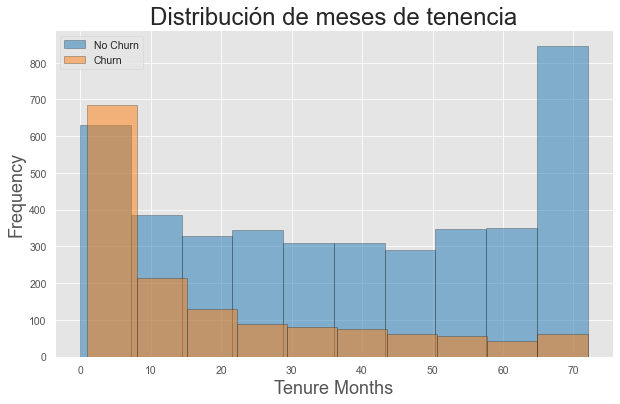

Saving figure tenecia_por_mes


<Figure size 432x288 with 0 Axes>

In [32]:
# histogram of the height
data2[data2['churn_value'] == 0].tenure_months.plot(kind='hist', 
                                                    color='tab:blue', 
                                                    edgecolor='black', 
                                                    alpha=0.5, 
                                                    figsize=(10,6))
data2[data2['churn_value'] == 1].tenure_months.plot(kind='hist', 
                                                    color='tab:orange', 
                                                    edgecolor='black', 
                                                    alpha=0.5, 
                                                    figsize=(10,6))

plt.legend(labels=['No Churn', 'Churn'])
plt.title('Distribución de meses de tenencia', size=24)
plt.xlabel('Tenure Months', size=18)
plt.ylabel('Frequency', size=18)
plt.tight_layout
plt.show()
save_fig('tenecia_por_mes')

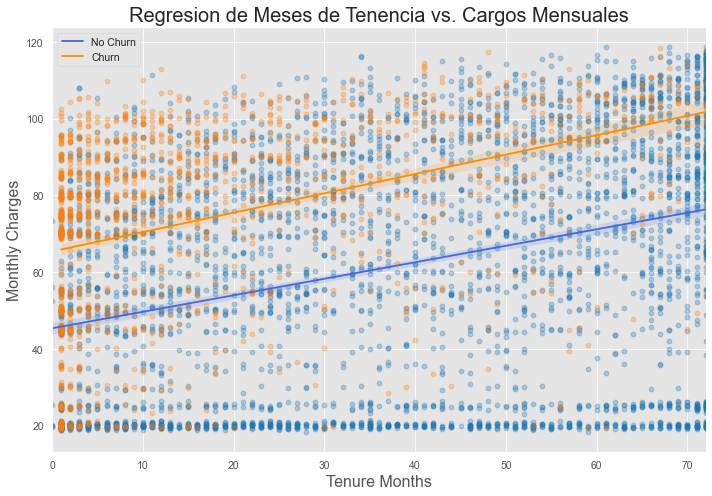

Saving figure tenecia_vs_cargos_mes


<Figure size 432x288 with 0 Axes>

In [33]:
# regression plot using seaborn
data2_0 = data2[data2['churn_value'] == 0]
data2_1 = data2[data2['churn_value'] == 1]

fig = plt.figure(figsize=(10, 7))
sns.regplot(data=data2_0, x='tenure_months', y='monthly_charges', 
            scatter_kws = {'color': 'tab:blue', 'alpha' : 0.3}, 
            line_kws={'color' : 'royalblue'}) 
sns.regplot(data=data2_1, x='tenure_months', y='monthly_charges', 
            scatter_kws = {'color': 'tab:orange', 'alpha' : 0.3}, 
            line_kws={'color' : 'darkorange'})

# Legend, title and labels.
plt.legend(labels=['No Churn', 'Churn'])
plt.title('Regresion de Meses de Tenencia vs. Cargos Mensuales', size=20)
plt.xlabel('Tenure Months', size=16)
plt.ylabel('Monthly Charges', size=16)
plt.tight_layout()
plt.show()
save_fig('tenecia_vs_cargos_mes')

## Graficas en Tableau

### Distribución demográfica de la tasa de fugas

<img src="images/tableau1.png" width="85%">

### Notas, observaciones

 *  No hay una visible diferencia entre la tasa de fuga por genero
 *  Las variables tener pareja, hijos y senior citizen, tienen tasas de abandono bajas
 *  La variable Streaming content para los clientes de Internet tiene una tasa de abandono ligeramente menor

### Tenure-Contract Churn¶

<img src="images/tableau2.png" width="85%">

### Scatter plot: cambios de tenencia

<img src="images/tableau3.png" width="85%">

### Fuga por grupos de producto

<img src="images/tableau4.png" width="85%">

### Análisis de correlaciones

In [34]:
# create column correlation matrix
corr = data2.corr()

# limit to churn target and drop non-predictive fields
corr_churn = corr.copy().loc[:, 'churn_value'].sort_values(ascending=False)
to_drop = ['zip_code', 'count', 'churn_value', 'churn_score', 
           'churn_rsn_grp_product', 'churn_rsn_grp_cust_svc', 
           'churn_rsn_grp_pricing', 'churn_rsn_grp_moved', 
           'churn_rsn_grp_unknown']
corr_churn = corr_churn.drop(to_drop)
corr_churn[(corr_churn>=0.15) | (corr_churn<=-0.15)]

contract_mtm          0.402
tenure_1yr            0.307
pmt_meth_echeck       0.303
internet_svc_fiber    0.302
p8_fib_bund_plus      0.210
p7_fib_bund_core      0.199
monthly_charges       0.193
paperless_billing     0.189
p6_dsl_bund_plus     -0.155
tech_support         -0.170
online_security      -0.170
contract_1yr         -0.178
p1_phone_only        -0.185
total_charges        -0.192
pmt_meth_auto        -0.207
internet_svc_none    -0.228
dependents           -0.247
tenure_4+yr          -0.259
contract_2yr         -0.299
tenure_months        -0.344
Name: churn_value, dtype: float64

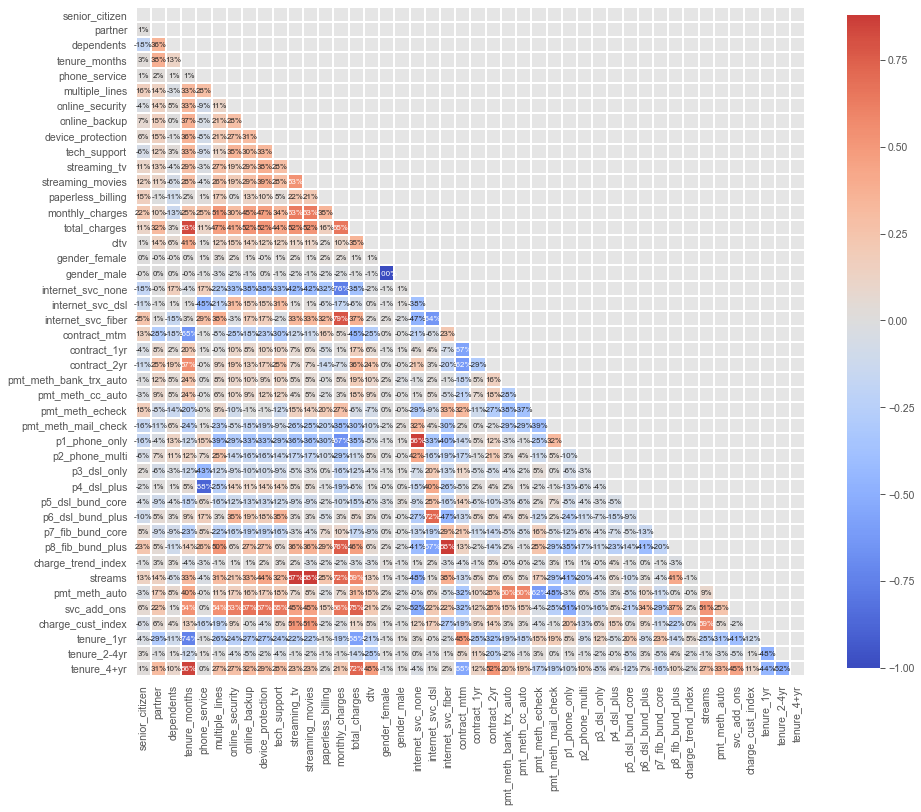

Saving figure correlaciones


<Figure size 432x288 with 0 Axes>

In [35]:
# show heatmap for correlation matrix
f, ax = plt.subplots(figsize=(15,15))
corr2 = corr.drop(to_drop).drop(to_drop, axis=1)
mask = np.zeros(corr2.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(corr2, mask = mask, fmt='.0%',
            center=0, linewidths=0.3, cmap='coolwarm', square=True, 
            annot=True, cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})
plt.tight_layout
plt.show()
save_fig('correlaciones')

In [36]:
# check for collinearity among potential predictors by pairs
df = (
     corr2
     .stack()
     .reset_index()
     .sort_values(0, ascending=False)
)
# zip the default name columns level_0 and level_1
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace=True)
# now drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)
# rename correlation column rather than 0
df.columns = ['correlation']
# drop duplicates and keep only pair correlations above 0.65
df.drop_duplicates(inplace=True)
df[abs(df.correlation) > .60]

,correlation
pairs,
"(senior_citizen, senior_citizen)",1.000
"(internet_svc_fiber, p8_fib_bund_plus)",0.878
"(streaming_movies, streams)",0.875
"(streaming_tv, streams)",0.875
"(p1_phone_only, internet_svc_none)",0.865
"(tenure_4+yr, tenure_months)",0.855
"(tenure_months, total_charges)",0.827
"(internet_svc_fiber, monthly_charges)",0.789
"(p8_fib_bund_plus, monthly_charges)",0.759


## Modelos estadísticos para analizar las fugas

Esta sección contiene una serie de funciones que serán uitlizadas más adelante en la selección de los modelos